## Imports

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.utils import resample
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import (
    RandomForestClassifier,
    VotingClassifier,
    AdaBoostClassifier,
    GradientBoostingClassifier
)
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.decomposition import TruncatedSVD
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix

from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import shap

import plotly.graph_objs as go
from plotly.offline import iplot, init_notebook_mode

## Preprocessing

In [11]:
# --- Preprocessing Function ---
def preprocessing_text(complaint):
    complaint = complaint.lower()
    complaint = re.sub(r'[^a-zA-Z\s]', '', complaint)
    complaint = re.sub(r'[x]{2,}', '', complaint)
    return complaint

df = pd.read_csv("complaint_cleaned.csv")
df['Product'] = df['Product'].replace(
    "Credit reporting, credit repair services, or other personal consumer reports",
    "Credit/Consumer Reporting"
)

selected_products = [
    "Credit/Consumer Reporting",
    "Debt collection",
    "Mortgage",
    "Credit card or prepaid card",
    "Checking or savings account",
    'Student loan'
]

df2 = df[df['Product'].isin(selected_products)][['Consumer complaint narrative', 'Product']].dropna()
df2 = df2.rename(columns={'Consumer complaint narrative': 'Consumer_complaint'})
df2['Consumer_complaint'] = df2['Consumer_complaint'].apply(preprocessing_text)

category_id_df = df2[['Product']].drop_duplicates().reset_index(drop=True)
category_id_df['category_id'] = category_id_df.index
df2 = df2.merge(category_id_df, on='Product')
df2['label'] = df2['category_id']

# Sample...or else
df3 = df2.copy()
df2 = df2.sample(n=10000, random_state=42)

/var/folders/qz/_plh__x56hj5r6twwvlby_rc0000gn/T/ipykernel_22099/1880848596.py:8: DtypeWarning:

Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.



## Creates a pie chart for distribution of product complaints

In [1]:
init_notebook_mode(connected=True)

p_product_discussions = round(df["Product"].value_counts() / len(df["Product"]) * 100, 2)

labels = list(p_product_discussions.index)
values = p_product_discussions.values.tolist()
colors = ['#F78181', '#F5A9BC', '#2E9AFE', '#58FA58', '#FAAC58', '#088A85', 
          '#8A0808', '#848484', '#F781F3', '#D7DF01', '#2E2EFE']

product_pie = go.Pie(
    labels=labels,
    values=values,
    marker=dict(colors=colors, line=dict(color='#000000', width=2))
)

layout = go.Layout(title='Product Types')
fig = go.Figure(data=[product_pie], layout=layout)
iplot(fig)


/var/folders/qz/_plh__x56hj5r6twwvlby_rc0000gn/T/ipykernel_22099/737356362.py:9: DtypeWarning:

Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.



## Creates a chart for the customer response from company

In [ ]:
company_response = df['Company response to consumer'].value_counts()

customer_res_plotly = go.Bar(
    x=company_response.index.values,
    y=company_response.values,
    text='Customer Response',
    showlegend=False,
    marker=dict(
        color=company_response.values,
        colorscale=[[0.0, 'rgb(165,0,38)'], [0.111, 'rgb(215,48,39)'], [0.222, 'rgb(244,109,67)'], 
                    [0.333, 'rgb(253,174,97)'], [0.444, 'rgb(254,224,144)'], 
                    [0.555, 'rgb(224,243,248)'], [0.666, 'rgb(171,217,233)'], 
                    [0.777, 'rgb(116,173,209)'], [0.888, 'rgb(69,117,180)'], 
                    [1.0, 'rgb(49,54,149)']],
        reversescale=True
    )
)

layout = go.Layout(
    title='Customer Response from Company',
    xaxis=dict(title='Response Type'),
    yaxis=dict(title='Number of Complaints')
)

fig = go.Figure(data=[customer_res_plotly], layout=layout)
iplot(fig)

## Company by Company to Explore

In [ ]:
cross_month = pd.crosstab(df['State'], df['Company']).apply(lambda x: x / x.sum() * 100)

df_boa = pd.DataFrame(cross_month['BANK OF AMERICA, NATIONAL ASSOCIATION']).reset_index().sort_values(by="BANK OF AMERICA, NATIONAL ASSOCIATION", ascending=False).round(2)
df_boa = df_boa.rename(columns={'BANK OF AMERICA, NATIONAL ASSOCIATION': 'share of complaints'})

for col in df_boa.columns:
    df_boa[col] = df_boa[col].astype(str)
    
    
scl = [[0.0, 'rgb(202, 202, 202)'],[0.2, 'rgb(253, 205, 200)'],[0.4, 'rgb(252, 169, 161)'],
            [0.6, 'rgb(247, 121, 108  )'],[0.8, 'rgb(255, 39, 39)'],[1.0, 'rgb(219, 0, 0)']]


df_boa['text'] = "State Code: " + df_boa['State'] + '<br>'


data = [ dict(
        type='choropleth',
        colorscale = scl,
        autocolorscale = False,
        locations = df_boa['State'],
        z = df_boa['share of complaints'], 
        locationmode = 'USA-states',
        text = df_boa['text'],
        marker = dict(
            line = dict (
                color = 'rgb(255,255,255)',
                width = 2
            ) ),
        colorbar = dict(
            title = "%")
        ) ]

layout = dict(
    title = 'Most Complaints by State <br> Bank of America',
    geo = dict(
        scope = 'usa',
        projection=dict(type='albers usa'),
        showlakes = True,
        lakecolor = 'rgb(255, 255, 255)')
)

fig = dict(data=data, layout=layout)
iplot(fig, filename='d3-cloropleth-map')

## Tokenize, preprocess

In [ ]:
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5,
                        ngram_range=(1, 2), 
                        stop_words='english')
features = tfidf.fit_transform(df2.Consumer_complaint).toarray()
labels = df2.category_id

X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(
    features, labels, df2.index, 
    test_size=0.25, 
    stratify=labels, 
    random_state=1
)

models = {
    'LinearSVC': LinearSVC(),
    'RandomForest': RandomForestClassifier(n_estimators=100, max_depth=5, random_state=1),
    'MultinomialNB': MultinomialNB(),
    'LogisticRegression': LogisticRegression(max_iter=1000, random_state=1)
}

for name, model in models.items():
    print(f"\n=== {name} ===")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    print("\nCLASSIFICATION REPORT:\n")
    print(metrics.classification_report(y_test, y_pred, target_names=category_id_df['Product'].values))

    # Confusion Matrix
    conf_mat = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_mat, annot=True, cmap="Blues", fmt='d',
                xticklabels=category_id_df['Product'].values, 
                yticklabels=category_id_df['Product'].values)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f"CONFUSION MATRIX - {name}", size=16)
    plt.tight_layout()
    plt.show()


## Hard voting ensemble method (since linear SVC doesn't support probabilities). Added lemmatization and removed stop words.

Each of the 10000 complaints is represented by 27678 features (TF-IDF score of unigrams and bigrams)


/Users/sarahpopeck/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning:

The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.




ENSEMBLE CLASSIFICATION REPORT:

                                                                              precision    recall  f1-score   support

                                                                    Mortgage       0.91      0.91      0.91       240
Credit reporting, credit repair services, or other personal consumer reports       0.85      0.94      0.89      1346
                                                             Debt collection       0.81      0.70      0.75       483
                                                 Credit card or prepaid card       0.78      0.68      0.73       215
                                                 Checking or savings account       0.89      0.76      0.82       141
                                                                Student loan       0.94      0.63      0.75        75

                                                                    accuracy                           0.85      2500
                    

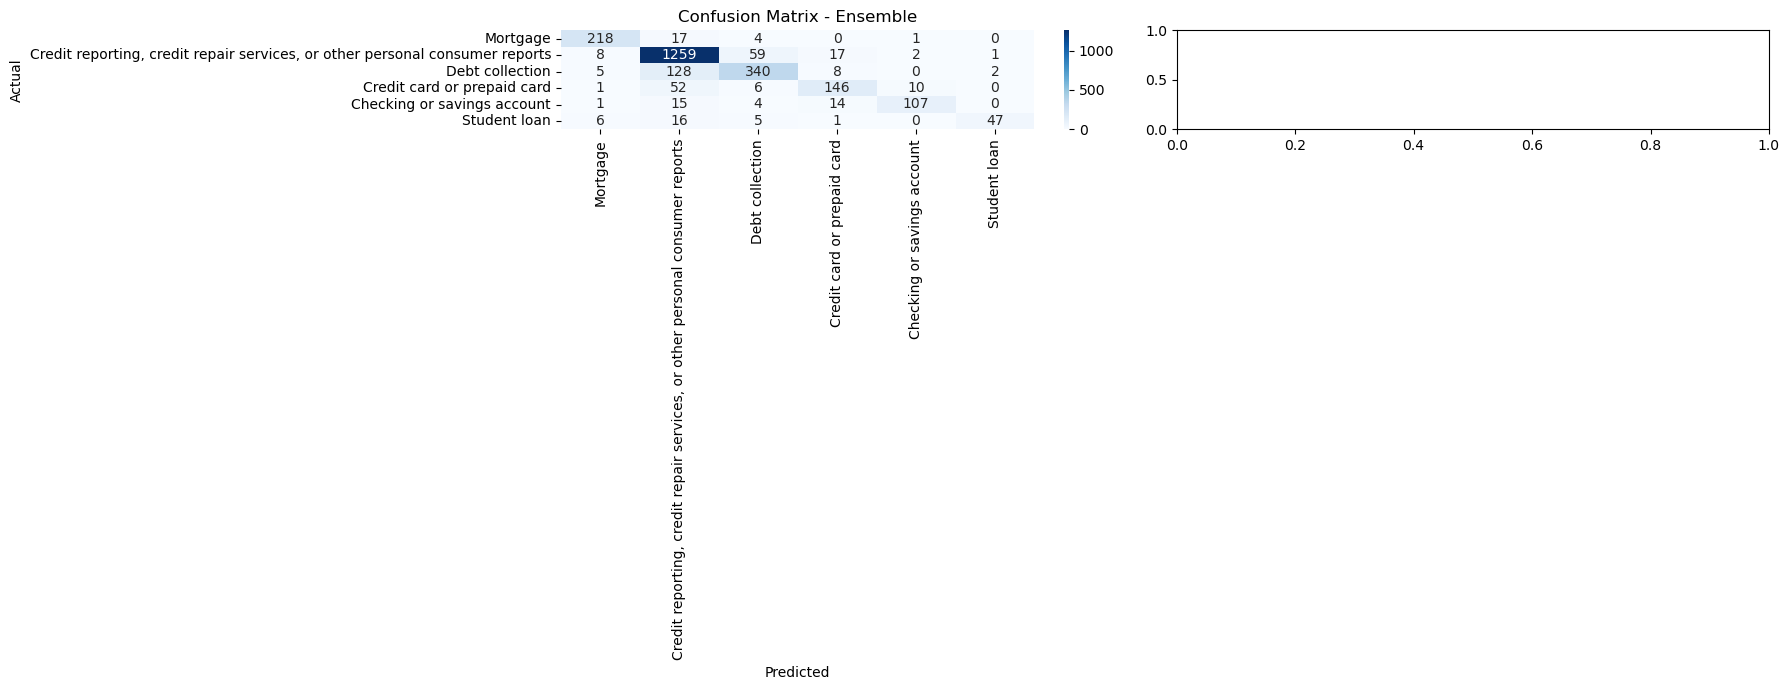

In [3]:
class TextPreprocessor(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.stop_words = set(stopwords.words('english'))
        self.lemmatizer = WordNetLemmatizer()

    def preprocess(self, complaint):
        complaint = complaint.lower()
        complaint = re.sub(r'[^a-zA-Z\s]', '', complaint)
        complaint = re.sub(r'[x]{2,}', '', complaint)
        words = complaint.split()
        words = [self.lemmatizer.lemmatize(w) for w in words if w not in self.stop_words]
        return ' '.join(words)

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X.apply(self.preprocess)

preprocessor = TextPreprocessor()
df2['Consumer_complaint'] = preprocessor.fit_transform(df2['Consumer_complaint'])

tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, ngram_range=(1, 2))
features = tfidf.fit_transform(df2.Consumer_complaint).toarray()
labels = df2.category_id

X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(
    features, labels, df2.index, 
    test_size=0.25, 
    stratify=labels, 
    random_state=1
)


model1 = ('LinearSVC', LinearSVC())
model3 = ('MultinomialNB', MultinomialNB())
model4 = ('LogisticRegression', LogisticRegression(max_iter=1000, random_state=1))
ensemble = VotingClassifier(estimators=[model1, model3, model4],
                            voting='hard')
ensemble.fit(X_train, y_train)
y_pred = ensemble.predict(X_test)

print("\nENSEMBLE CLASSIFICATION REPORT:\n")
print(metrics.classification_report(y_test, y_pred, target_names=category_id_df['Product'].values))

fig, axs = plt.subplots(1, 2, figsize=(18, 7))

sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, cmap="Blues", fmt='d', ax=axs[0],
            xticklabels=category_id_df['Product'].values, yticklabels=category_id_df['Product'].values)
axs[0].set_title("Confusion Matrix - Ensemble")
axs[0].set_xlabel('Predicted')
axs[0].set_ylabel('Actual')

plt.tight_layout()
plt.show()


## Ensemble using Gradient Boosting and soft voting - couldn't handle size

In [ ]:
class TextPreprocessor(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.stop_words = set(stopwords.words('english'))
        self.lemmatizer = WordNetLemmatizer()

    def preprocess(self, complaint):
        complaint = complaint.lower()
        complaint = re.sub(r'[^a-zA-Z\s]', '', complaint)
        complaint = re.sub(r'[x]{2,}', '', complaint)
        words = complaint.split()
        words = [self.lemmatizer.lemmatize(w) for w in words if w not in self.stop_words]
        return ' '.join(words)

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X.apply(self.preprocess)

preprocessor = TextPreprocessor()
df2['Consumer_complaint'] = preprocessor.fit_transform(df2['Consumer_complaint'])

tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, ngram_range=(1, 2))
features = tfidf.fit_transform(df2.Consumer_complaint).toarray()
labels = df2.category_id

X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(
    features, labels, df2.index,
    test_size=0.25,
    stratify=labels,
    random_state=1
)

model1 = ('RandomForest', RandomForestClassifier(n_estimators=100, max_depth=5, random_state=1))
model2 = ('MultinomialNB', MultinomialNB())
model3 = ('LogisticRegression1', LogisticRegression(max_iter=1000, random_state=1))
model4 = ('GradientBoosting', GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=1))

ensemble = VotingClassifier(
    estimators=[model1, model2, model3, model4],
    voting='soft'
)

cv_scores = cross_val_score(ensemble, features, labels, cv=5, scoring='accuracy')
print("\nCROSS-VALIDATION SCORES (5-Fold):", cv_scores)
print("Mean Accuracy:", np.mean(cv_scores))

ensemble.fit(X_train, y_train)
y_pred = ensemble.predict(X_test)

print("\nSOFT VOTING ENSEMBLE CLASSIFICATION REPORT:\n")
print(metrics.classification_report(y_test, y_pred, target_names=category_id_df['Product'].values))

plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, cmap="Blues", fmt='d',
            xticklabels=category_id_df['Product'].values,
            yticklabels=category_id_df['Product'].values)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title("CONFUSION MATRIX - Soft Voting Ensemble", size=16)
plt.tight_layout()
plt.show()


In [ ]:
import shap

# --- Feature Importance Visualization (Random Forest only) ---
feature_names = tfidf.get_feature_names_out()
importances = ensemble.named_estimators_['RandomForest'].feature_importances_
indices = np.argsort(importances)[-20:][::-1]  # Top 20 features

plt.figure(figsize=(10, 6))
plt.title("Top 20 Important Features (Random Forest)")
plt.barh(range(len(indices)), importances[indices], align="center")
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.gca().invert_yaxis()
plt.xlabel("Feature Importance")
plt.tight_layout()
plt.show()

In [ ]:
# --- SHAP Explainers for Logistic Regression and Random Forest ---
print("\nSHAP SUMMARY PLOTS\n")

# Logistic Regression
explainer_lr = shap.Explainer(ensemble.named_estimators_['LogisticRegression'], X_train)
shap_values_lr = explainer_lr(X_test[:100])
shap.summary_plot(shap_values_lr, features=X_test[:100], feature_names=feature_names, show=False)
plt.title("SHAP Summary - Logistic Regression")
plt.show()

# Random Forest
explainer_rf = shap.Explainer(ensemble.named_estimators_['RandomForest'], X_train)
shap_values_rf = explainer_rf(X_test[:100])
shap.summary_plot(shap_values_rf, features=X_test[:100], feature_names=feature_names, show=False)
plt.title("SHAP Summary - Random Forest")
plt.show()

# Force plot for the first sample
shap.initjs()
shap.force_plot(explainer_nb.expected_value[0], shap_values_nb[0][0], X_test[0], feature_names=feature_names, matplotlib=True)
plt.title("SHAP Force Plot - MultinomialNB (First Test Sample)")
plt.show()

## Adaboost: Low accuracy rate, was not used

In [ ]:
base_estimator = DecisionTreeClassifier(max_depth=1)
adaboost_model = AdaBoostClassifier(base_estimator=base_estimator, n_estimators=100, random_state=1)
adaboost_model.fit(X_train, y_train)
y_pred_ada = adaboost_model.predict(X_test)

print("\nADABOOST CLASSIFICATION REPORT:\n")
print(metrics.classification_report(y_test, y_pred_ada, target_names=category_id_df['Product'].values))

sns.heatmap(confusion_matrix(y_test, y_pred_ada), annot=True, cmap="Purples", fmt='d', ax=axs[1],
            xticklabels=category_id_df['Product'].values, yticklabels=category_id_df['Product'].values)
axs[1].set_title("Confusion Matrix - AdaBoost")
axs[1].set_xlabel('Predicted')
axs[1].set_ylabel('Actual')

## Logistic Regression and Linear SVC utilizing something called SVD to reduce dimensionality, allowing for handling of way larger sample sizing

/Users/sarahpopeck/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning:

The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.




=== CLASSIFICATION REPORT ===

                             precision    recall  f1-score   support

  Credit/Consumer Reporting       0.81      0.83      0.82      2500
            Debt collection       0.81      0.81      0.81      2500
                   Mortgage       0.93      0.93      0.93      2500
Credit card or prepaid card       0.84      0.83      0.83      2500
               Student loan       0.93      0.90      0.92      2500
Checking or savings account       0.88      0.90      0.89      2500

                   accuracy                           0.87     15000
                  macro avg       0.87      0.87      0.87     15000
               weighted avg       0.87      0.87      0.87     15000



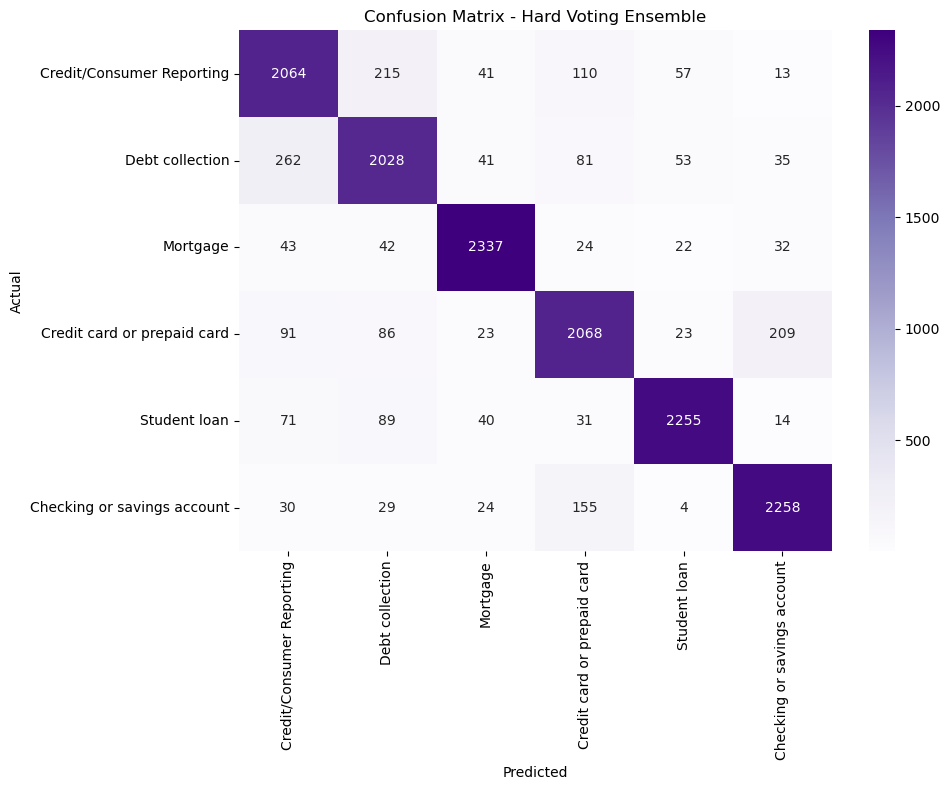

In [13]:
samples_per_class = 60000 // df3['label'].nunique()

df_list = []
for label in df3['label'].unique():
    df_class = df3[df3['label'] == label]
    df_upsampled = resample(
        df_class,
        replace=True,
        n_samples=samples_per_class,
        random_state=42
    )
    df_list.append(df_upsampled)

df_bal = pd.concat(df_list)


tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, ngram_range=(1, 3), stop_words='english')
features = tfidf.fit_transform(df_bal['Consumer_complaint'])
labels = df_bal['label']

svd = TruncatedSVD(n_components=300, random_state=42)
features_reduced = svd.fit_transform(features)

X_train, X_test, y_train, y_test = train_test_split(
    features_reduced, labels,
    test_size=0.25,
    stratify=labels,
    random_state=1
)

model1 = ('LogisticRegression', LogisticRegression(max_iter=1000, class_weight='balanced', random_state=1))
model2 = ('LinearSVC', LinearSVC(class_weight='balanced', random_state=2))

ensemble = VotingClassifier(
    estimators=[model1, model2],
    voting='hard',
    weights=[2, 2]
)

ensemble.fit(X_train, y_train)
y_pred = ensemble.predict(X_test)

print("\n=== CLASSIFICATION REPORT ===\n")
print(classification_report(y_test, y_pred, target_names=category_id_df['Product'].values))

conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Purples',
            xticklabels=category_id_df['Product'].values,
            yticklabels=category_id_df['Product'].values)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Hard Voting Ensemble')
plt.tight_layout()
plt.show()
